In [1]:
import configparser
import datetime as dt
import sys
import collections
from pathlib import Path
from typing import Union, Optional, List

import codebook.EDA as EDA
import codebook.clean as clean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.style.use('raph-base')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 30)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

np.random.seed(666)

In [3]:
Path.cwd().parent / 'src'

WindowsPath('C:/Users/r2d4/OneDrive/code/projects/20-02_disco/src')

In [4]:
sys.path.append(str(Path.cwd().parent))

from src.db_declaration import Base, Record
from src import insert_record
from src import utils

<class 'sqlalchemy.ext.declarative.api.DeclarativeMeta'>


In [5]:
print(sys.executable)
print(sys.version)
print(f'sqlalchemy {sqlalchemy.__version__}')

C:\Users\r2d4\miniconda3\envs\py3\python.exe
3.8.3 (default, May 19 2020, 06:50:17) [MSC v.1916 64 bit (AMD64)]
sqlalchemy 1.3.17


## Inititial Data Ingestion

In [6]:
CONFIG_PATH = Path.cwd().parent / "config.cfg"

### Re-Create DB

In [7]:
path_to_db = utils.read_config_return_str(CONFIG_PATH, "SQLITE")
engine = utils.create_engine(path_to_db)
session = utils.create_session(engine)
utils.create_DB_anew(engine, Base)

C:\Users\r2d4\OneDrive\code\projects\20-02_disco\db_aka_discobase\DiscoBase.db


### "Bulk" Load Data Into DB - NOT WORKING WITH TABLE RELATIONSHIPS

This is a fast approach using sqlalchemy core language, the problem is it copies the data from a df into a table, but does not take care of the relationships - the foreign keys are not created.

Btw: This is not the really fast bulk load with `conn.executemany()`, see [here](https://stackoverflow.com/a/32239587/13797028).

In [8]:
def load_albums_from_xlsx(
    filepath: Union[Path, str], genres: Optional[List] = None
) -> pd.DataFrame:
    """Load the original album collection file into a dataframe.
    You can specify a list of genres you want to include
    (defaults to None).
    """
    df = pd.read_excel(filepath, engine="openpyxl")
    if genres:
        df = df[df["Genre"].isin(genres)]
    return df

**TODO:** see the cleaning, this has to be formalized in a function

In [9]:
path_to_collection = utils.read_config_return_str(CONFIG_PATH, "COLLECTION")
collection_df = load_albums_from_xlsx(path_to_collection)
collection_df = clean.prettify_column_names(collection_df)
collection_df.dropna(thresh=8, inplace=True)
collection_df["purchase_date"] = collection_df["purchase_date"].dt.date.astype(str)
collection_df["number"] = collection_df["number"].astype(str)
# collection_df["digitized"] = collection_df["digitized"].map({True: 1, False: 0}).astype(int)
collection_df["label"].fillna("NA", inplace=True)  # because it creates a foreign key


In [10]:
collection_df.shape
collection_df.info()

(293, 15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 292
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   active         293 non-null    float64
 1   artist         293 non-null    object 
 2   title          293 non-null    object 
 3   format         293 non-null    object 
 4   year           293 non-null    float64
 5   genre          293 non-null    object 
 6   price          293 non-null    float64
 7   purchase_date  293 non-null    object 
 8   vinyl_color    197 non-null    object 
 9   lim_edition    207 non-null    object 
 10  number         293 non-null    object 
 11  label          293 non-null    object 
 12  digitized      293 non-null    object 
 13  remarks        72 non-null     object 
 14  rating         101 non-null    float64
dtypes: float64(4), object(11)
memory usage: 36.6+ KB


In [11]:
EDA.display_nan(collection_df)

,total,prop,dtype
remarks,221,75.4%,object
rating,192,65.5%,float64
vinyl_color,96,32.8%,object
lim_edition,86,29.4%,object


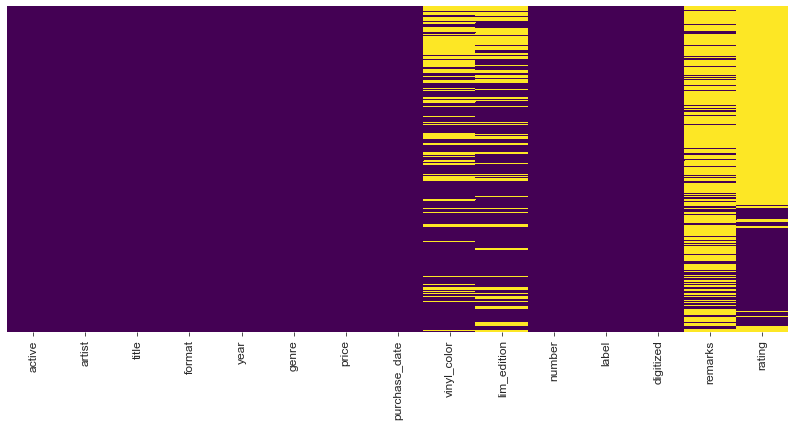

In [12]:
EDA.plot_nan(collection_df)

In [13]:
test_record = collection_df.to_dict("records")[-30]
test_record

{'active': 1.0,
 'artist': 'Living Gate',
 'title': 'Death Lust',
 'format': 'MLP',
 'year': 2020.0,
 'genre': 'Death Metal',
 'price': 20.0,
 'purchase_date': '2020-07-01',
 'vinyl_color': 'milky clear with blood red, black and white splatter',
 'lim_edition': 250,
 'number': 'nan',
 'label': 'Relapse Records',
 'digitized': True,
 'remarks': 'warped, etched on B-Side',
 'rating': 8.0}

In [14]:
def insert_df_with_sqlalchemy_core(df, table_class, engine):
    start = time.time()
    engine.execute(
        table_class.__table__.insert(),
        [x for x in df.to_dict("records")]
    )
    end = time.time()
    print("SQLAlchemy Core: Insert {0} records in {1} seconds".format(
        str(len(df)), str(end - start)
        )
     )

In [15]:
import time

insert_df_with_sqlalchemy_core(collection_df, Record, engine)

SQLAlchemy Core: Insert 293 records in 0.07899785041809082 seconds


In [16]:
list(Record.__table__.columns)

[Column('record_id', INTEGER(), table=<records>, primary_key=True, nullable=False),
 Column('artist_id', INTEGER(), ForeignKey('artists.artist_id'), table=<records>),
 Column('title', TEXT(), table=<records>, nullable=False),
 Column('genre_id', INTEGER(), ForeignKey('genres.genre_id'), table=<records>),
 Column('label', INTEGER(), ForeignKey('labels.label_id'), table=<records>),
 Column('year', INTEGER(), table=<records>),
 Column('format_id', INTEGER(), ForeignKey('formats.format_id'), table=<records>),
 Column('vinyl_color', TEXT(), table=<records>),
 Column('lim_edition', TEXT(), table=<records>),
 Column('number', TEXT(), table=<records>),
 Column('remarks', TEXT(), table=<records>),
 Column('purchase_date', TEXT(), table=<records>, nullable=False),
 Column('price', REAL(), table=<records>, nullable=False),
 Column('digitized', INTEGER(), table=<records>, nullable=False),
 Column('rating', INTEGER(), table=<records>),
 Column('active', INTEGER(), table=<records>, nullable=False)]

In [17]:
# Reset DB
utils.create_DB_anew(engine, Base)

## Test "add_new_record"

**TODO**: Do I have to loop? Using apply only after all is done would be more efficient

In [18]:
insert_record.add_new_record(session, test_record)

In [19]:
test_record

{'active': 1.0,
 'artist': 'Living Gate',
 'title': 'Death Lust',
 'format': 'MLP',
 'year': 2020.0,
 'genre': 'Death Metal',
 'price': 20.0,
 'purchase_date': '2020-07-01',
 'vinyl_color': 'milky clear with blood red, black and white splatter',
 'lim_edition': 250,
 'number': 'nan',
 'label': 'Relapse Records',
 'digitized': True,
 'remarks': 'warped, etched on B-Side',
 'rating': 8.0}

### Add all records

**TODO:** Can I apply()?

In [20]:
def insert_df_with_sqlalchemy_orm(session, df):
    for x in df.to_dict("records"):
        insert_record.add_new_record(session, x)

In [21]:
insert_df_with_sqlalchemy_orm(session, collection_df)

Record 'Death Lust' by Living Gate already exists, insert skipped.


## Query DB

In [22]:
session.query(Record).count()

293

In [23]:
for result in session.query(Record).filter(Record.title == "Death Lust").all():
    result

<Record(record_id=1 title=Death Lust artist_id=1)>